In [1]:
%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from IPython.display import Image, HTML, display
from gensim import corpora, models
from pytagcloud import create_tag_image, make_tags, LAYOUT_MIX
from pytagcloud.colors import COLOR_SCHEMES
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.datasets
import pprint as p
import numpy as np
import pandas as pd
import pickle as pkl
import logging
import bz2
import os

# requires:
# - nltk
# - pygame
# - simplejson

pygame 2.0.1 (SDL 2.0.14, Python 3.7.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


/Users/whitneyking/miniconda3/envs/databricks-ml-7-1/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict


In [2]:
root_dir = os.getcwd()

In [3]:
# cd into ./data, run:
# wget http://www.cs.columbia.edu/~blei/lda-c/ap.tgz
# tar xzf ap.tgz

os.chdir(f'{root_dir}/text_corpus')
from TextCorpus import *     # import Python file in plain Python

In [4]:
def line():
    print('-' * 80)
        
def create_cloud(oname, words, size=(1200, 300), maxsize=50, minsize=15
               , background=(100, 100, 100, 255), fontname='IM Fell DW Pica'
               , colors=COLOR_SCHEMES['audacity'], rectangular=True):
    words = [(w,int(v*100000)) for w,v in words]
    tags = make_tags(words, maxsize=maxsize, minsize=minsize, colors=colors)
    create_tag_image(tags, oname, size=size
                   , layout=LAYOUT_MIX, fontname=fontname
                   , background=background
                   , rectangular=rectangular)
    
    
# Setup Logging - nice to have so we have status updates along the way
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO)

## Topic Modeling
Clustering is useful if you need subjects to be categorized into distinct groups.
However, in many circumstances data needs to be allowed to exist in more than
group simultaneously. This is what we refer to as topics.

Some documents may have a topic that is central to the theme of the text,
while refering to other sub **topics** in the same text only in passing.
Dealing with the identification of which topic is central and which topics are
peripheral is the subfield of machine learning called **topic modeling**.

### Latent Dirichlet Allocation (LDA)
Not to be confused with the classification method *linear discriminant analysis*.

LDA, when it comes to topic modeling are a class of generative models.
They contain a simplified fable about how the data was generated.
In the LDA fable, topics are created by first assigning probability weights
to words, each topic with a different weight.
When a new document is to be generated, we pick the topics we want to use,
and then mix in words associated with that topic. Order of words does not matter,
so a bag of words method is used.

In general, this is a grave over simplification for how the LDA algorithm works,
but for machine learning purposes, knowing which words were used in which
topics, and their frequencies is good enough to start making decisions.

### Building a Topic Model
Of course, starting out we don't actually know what our topics are,
or what words each of those yet to be known topics are associated with.
First, we need to reverse engineer a collection of text into a fable to
be able to discover the topics available, as well as which topics are in
each text.

To handle latent Dirichlet allocation, we will need to use ```Gensim```
which is developed by Radim Řehůřek who is a machine learning researcher
and consultant in the United Kingdom. The dataset for this section will
come from the Associated Press (AP) Blei Corpus.

In [5]:
# to get the Blei dataset, cd into ./data then run:
#    curl http://www.cs.columbia.edu/\~blei/lda-c/ap.tgz --output ap.tgz
#    tar xzf ap.tgz

# gensim has some built in logic for working with the blei dataset
os.chdir(f'{root_dir}/data/ap')
corpus = corpora.BleiCorpus('ap.dat', 'vocab.txt')
print(corpus)

2021-02-12 13:14:12,464 : INFO : loading corpus from ap.dat


In [6]:
# Corpus Preprocessing-----------------------------------------------------------
# we use sklearn CountVectorizer to identify stop words
# these are low entropy words
sw = CountVectorizer(min_df=1, stop_words='english')
stop_words = sorted(sw.get_stop_words())
print(stop_words)

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', 'get', 'give

In [7]:
# parse data out into objects we can work with
name = 'ap'
vocab_raw = open('vocab.txt', 'r') # raw vocab

# generate a file to store clean/processed vocab
vocab_cl = open(f'{name}_vocab_clean.txt', 'w')
N_TOPICS = 100 # cap max  number of topics

# Remove stop words from vocabulary; very basic cleanup
# These won't make especially informative topics
vocab_clean = []
for line in vocab_raw:
    vocab_clean.append(
        [word for word in line.lower().split()
         if word not in stop_words]) # only keep words not in stop_words

vocab = []
for word in vocab_clean:
    if word:  # this helps prevent errors
        vocab_cl.write(word[0] + '\n') # one clean word per line
        vocab.append(word)
vocab_cl.close()  # save our clean word dataset
vocab_raw.close()

# tokenize words by storing them in a dictionary array
dictionary = corpora.Dictionary(vocab)
print(dictionary)

2021-02-12 13:16:50,619 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-02-12 13:16:50,708 : INFO : adding document #10000 to Dictionary(10000 unique tokens: ['new', 'percent', 'people', 'year', 'million']...)
2021-02-12 13:16:50,712 : INFO : built Dictionary(10408 unique tokens: ['new', 'percent', 'people', 'year', 'million']...) from 10408 documents (total 10408 corpus positions)


Dictionary(10408 unique tokens: ['new', 'percent', 'people', 'year', 'million']...)


In [8]:
print('Vocab Cleanup Output:')
print(f'Raw: {len(vocab_clean)}\t' +
      f'Clean: {len(vocab)}\t' +
      f'Stop Word Dict: {len(stop_words)}')

Vocab Cleanup Output:
Raw: 10473	Clean: 10408	Stop Word Dict: 318


In [9]:
# Build corpus/bag of words with truncated vocabulary
ap_txt = open('ap.txt', 'r')
ap_data = [dictionary.doc2bow(line.lower().split()) for line in ap_txt]
p.pprint(ap_data[3][:10]) # peek at the bag of words - what do you see?

ap_docs = []
for doc in ap_data:
    if doc:
        ap_docs.append(doc)

[(2, 1),
 (3, 1),
 (7, 1),
 (8, 7),
 (22, 1),
 (31, 1),
 (53, 1),
 (56, 2),
 (94, 1),
 (100, 1)]


In [10]:
# corpus_clean = corpora.BleiCorpus.serialize(f'{name}_clean.dat', ap_docs, dictionary)

# Cleaned Data Model------------------------------------------------------------------------
corpus = corpora.BleiCorpus(f'{name}_clean.dat'
                          , f'{name}_clean.dat.vocab')

2021-02-12 13:20:00,048 : INFO : loaded corpus index from ap_clean.dat.index
2021-02-12 13:20:00,049 : INFO : loading corpus from ap_clean.dat


The ```corpus``` variable hold all of the text documents, and will allow us to easily build a topic model using it's structure as input. The below ```model``` constructor will allow us to statistically infer which topics are present in the corpus, and we can explore the resulting model in a lot of various ways. The list of topics resulting from the model can be output using the models ```[doc]``` syntax.

To train a basic LDA Model, we input the raw corpus, the number of topics desired as output, and the vocabulary to use as topic ids. In the case of the Blei corpus, the vocabulary list was pregenerated, however, **```gensim``` does come with a ```Dictionary``` class that has built-in functions which will populate a vocabulary dictionary for this purpose from a raw corpus if you don't already have one.**

In [11]:
# --- create and save a new model
lda_model = models.ldamodel.LdaModel(corpus
                                   , num_topics=N_TOPICS
                                   , id2word=corpus.id2word)
lda_model.save(f'{name}_lda1.pkl')

# --- load a saved model
# lda_model = models.ldamodel.LdaModel.load(f'{name}_lda1.pkl')

doc = corpus.docbyoffset(0)
topics = lda_model[doc]
p.pprint(topics)

2021-02-12 13:21:58,159 : INFO : using symmetric alpha at 0.01
2021-02-12 13:21:58,161 : INFO : using symmetric eta at 0.01
2021-02-12 13:21:58,164 : INFO : using serial LDA version on this node
2021-02-12 13:21:58,278 : INFO : running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 2246 documents, updating model once every 2000 documents, evaluating perplexity every 2246 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-12 13:21:58,279 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-02-12 13:21:58,544 : INFO : PROGRESS: pass 0, at document #2000/2246
2021-02-12 13:22:01,536 : INFO : merging changes from 2000 documents into a model of 2246 documents
2021-02-12 13:22:01,595 : INFO : topic #33 (0.010): 0.012*"people" + 0.007*"government" + 0.006*"percent" + 0.006*"police" + 0.005*"new" + 0.005*"soviet" + 0.005*"officials" + 0.004*"report" +

[(0, 0.024181819),
 (1, 0.059830155),
 (3, 0.03517097),
 (10, 0.014386972),
 (15, 0.019867819),
 (27, 0.43010947),
 (44, 0.03347766),
 (60, 0.019919598),
 (66, 0.07034138),
 (78, 0.015612677),
 (87, 0.018769594),
 (90, 0.019759212),
 (93, 0.14558713),
 (96, 0.04224534),
 (99, 0.03926388)]


In [12]:
lda_model.print_topics(2)

2021-02-12 13:24:58,182 : INFO : topic #46 (0.010): 0.009*"souter" + 0.008*"salinas" + 0.008*"democrats" + 0.007*"seoul" + 0.006*"police" + 0.005*"olympics" + 0.005*"president" + 0.005*"senate" + 0.005*"kennedy" + 0.005*"player"
2021-02-12 13:24:58,183 : INFO : topic #75 (0.010): 0.020*"koch" + 0.018*"cat" + 0.009*"style" + 0.006*"new" + 0.006*"politicians" + 0.006*"mayor" + 0.005*"president" + 0.005*"british" + 0.005*"indians" + 0.005*"party"


[(46,
  '0.009*"souter" + 0.008*"salinas" + 0.008*"democrats" + 0.007*"seoul" + 0.006*"police" + 0.005*"olympics" + 0.005*"president" + 0.005*"senate" + 0.005*"kennedy" + 0.005*"player"'),
 (75,
  '0.020*"koch" + 0.018*"cat" + 0.009*"style" + 0.006*"new" + 0.006*"politicians" + 0.006*"mayor" + 0.005*"president" + 0.005*"british" + 0.005*"indians" + 0.005*"party"')]

It's very important to note that this algorithm **uses some elements of randomness when it trains it's model**. This means that every time it trains, the result will be slightly different. If the data is well normalized, some of the qualitative properties of the model will be stable across multiple runs, but there will always be al element of variability here. In general, the **topics should remain pretty robust, but the order you see them show up in is going to change**.

The format of the topic results is return in a list of tuples: ```(topic_index, topic_weight)```

There are only a few topics used for each document, and the model is sparsely populated (lots of topics have no weight at all) Technically all topics in the LDA model have a non-zero probability, it's just that the probability is so small they're not showing up here, because zero is the best approximation. 

To further explore this, let's take a look at the data in a histogram.

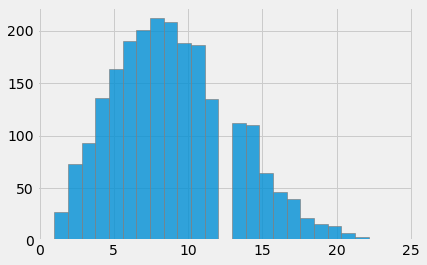

In [13]:
num_topics = [len(lda_model[doc]) for doc in corpus]

lda1 = plt.hist(num_topics, bins=25, edgecolor='grey', linewidth=.8, alpha=.8)

**previous analysis on different model** -> We can see in this histogram that the vast majority of documents have somewhere in the range of 8 - 12 topics; about 150 have around 5 topics, and then none have more than around 20 topics.

This is due in part to an invisible parameter we used, ```alpha```. Alpha is typically set between 0 and 1; the larger the value for alpha, the more topics will be returned per document.

By default, ```alpha``` is set to ```1 / num_topics```, however it can be explictly set in the LcaModel constructor. The next histogram compares the previous model with the same model set to alpha 1, and we can see as we would expect, more topics assigned to each document, this time averaging higher. If we were to set the alpha lower, we'd observe the opposite effect and have a lower more decerning number of topics.

In [14]:
# --- create and save a new model
lda_model2 = models.ldamodel.LdaModel(corpus
                              , num_topics = N_TOPICS
                              , id2word = corpus.id2word
                              , alpha = 1)

lda_model2.save('{0}_lda2.pkl'.format(name))

# --- load a saved model
# lda_model2 = models.ldamodel.LdaModel.load('{0}_lda2.pkl'.format(name))

2021-02-12 13:29:02,153 : INFO : using symmetric eta at 0.01
2021-02-12 13:29:02,156 : INFO : using serial LDA version on this node
2021-02-12 13:29:02,263 : INFO : running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 2246 documents, updating model once every 2000 documents, evaluating perplexity every 2246 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-12 13:29:02,263 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-02-12 13:29:02,486 : INFO : PROGRESS: pass 0, at document #2000/2246
2021-02-12 13:29:03,962 : INFO : merging changes from 2000 documents into a model of 2246 documents
2021-02-12 13:29:04,012 : INFO : topic #93 (1.000): 0.006*"new" + 0.006*"president" + 0.006*"percent" + 0.005*"people" + 0.004*"government" + 0.004*"million" + 0.003*"united" + 0.003*"years" + 0.003*"national" + 0.003*"state"
2021-02-12 13:29:04,014 : INF

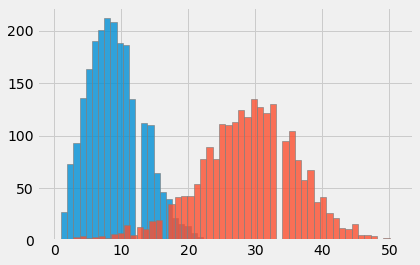

In [15]:
num_topics2 = [len(lda_model2[doc]) for doc in corpus]
# alpha in the plot is not to be confused with alpha in the LDA model
# in a plot, alpha indicates opacity
lda1 = plt.hist(num_topics, bins=25, edgecolor='grey', linewidth=.8, alpha=.8)
lda2 = plt.hist(num_topics2, bins=54, edgecolor='grey', linewidth=.8, alpha=.8)
plt.show()

### Identifying Topics

**So what exactly are these mysterious topics?** They're multinomial distributions over words.

That means that each topic assigns a probability to a word in the vocabulary. Words with a higher probability are more associated with a topic than words with a lower probability. In general, human brains have a hard time making sense of probability, but we don't have too hard of a time with lists, so it's easier to summarize these results by most highly weighted words.

In [16]:
# Iterate over all the topics in the model
for ti in range(lda_model.num_topics):
    words = lda_model.show_topic(ti, 64) # Gets word frequencies
    tf = sum(f for _, f in words)
    with open('{0}_topics.txt'.format(name), 'w') as output: # Output topics to text file
        output.write('\n'.join('{}:{}'.format(w, int(1000. * f / tf)) for w, f in words))
        output.write("\n\n\n")

In [17]:
top_10 = []
df_top10 = []
for topic in range(10):
    top_10.append([(w, f) for w, f in lda_model.show_topic(topic, 64)])
    df_top10.append([w for w, f in lda_model.show_topic(topic, 64)])

Next, we can take a look at the most frequently occuring words in each of the top 10 topics to get a better idea of what each topic is about. These topics can even be made into word clouds for easy visualization of which words are most occurant in each topic.

In [18]:
# Top 10 Topics
df_top10 = pd.DataFrame(df_top10).transpose()
df_top10[:20]

,0,1,2,3,4,5,6,7,8,9
0,government,government,thornburgh,beaten,ranch,drug,garbage,ag,south,mohawk
1,china,school,young,presumed,electoral,aids,new,bus,anderson,illinois
2,harassment,state,plaza,gunpoint,mad,immune,loan,corn,african,party
3,fetal,new,argentina,daniel,prison,infected,bank,greyhound,venus,violence
4,fiction,board,address,people,years,venus,savings,buses,troops,districts
5,resigned,million,raul,funeral,criminal,police,solid,gravley,sanctions,police
6,president,year,people,indian,counseling,people,epa,gunter,parish,seats
7,patrons,president,rebels,area,taxpayers,united,techniques,million,american,march
8,nonviolent,university,president,county,time,blood,household,sales,nelson,people
9,visit,money,atlanta,dickey,program,deficiency,regulators,company,man,new


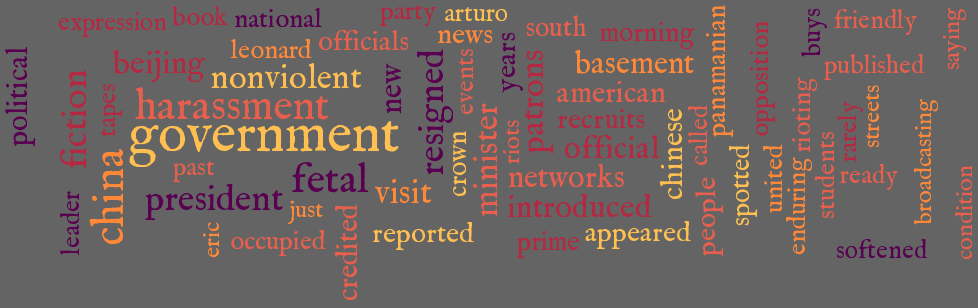

In [23]:
create_cloud(f'./{name}_top10topic.png', top_10[0])
Image(filename=f'./{name}_top10topic.png') 

### Comparing Documents By Topic

Topics give us a window in which to establish a viewpoint and navigate large collections of documents. In general, *topics are a tool in which to establish an end to a means*. 

Now that we've gotten estimates for each documents topics, we can compare the documents in the **topic space**. Instead of comparing documents by word similarity, we will say they are similar if they discuss the same topics. To project the topics to the topic space, we need to have a vector of topics that summarize each document; this is a form of dimensionality reduction.

Topic spaces can be extremely useful when it comes to machine learning and text datasets, because **many documents that discuss the same topics may actually not use many of the same words**. Instead, they may use a lot of similar constructions or concepts. Topic models can be great on their own for data exploration, as we've begun to see with the above data frame, however they're an extremely powerful intermediate tool for many other tasks. Once topics have been computed, operations can be performed on the topic vectors, and we don't need to pay attention to the original words. In fact, we may find these underlying topics more informative than the raw words that madeup the corpus.

We'll rexplore this using the **```20newsgroup``` dataset**, this time using topic vectors to compare similarity instead of word vectors to expore these concepts.

In [17]:
os.chdir(f'{root_dir}/text_corpus')
from TextCorpus import Topics as tc, PreProcessText as pt

os.chdir(f'{root_dir}/data/20news')
# this time we use NLTKs version of stop words
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/whitneyking/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# Create 20newgroup training dataset
name = '20news'
news_dataset = sklearn.datasets.fetch_20newsgroups(subset='train')

news_raw_text = news_dataset.data
news_vocab = news_dataset.data

# Get words
news_vocab = pt.GetWords(news_vocab)

# processing and cleaning text generally takes a lot more effort than just removing stop words
# below are some custom functions for common text processing operations, in the TextCorpus module

# Remove noise
news_vocab = pt.ClearNoiseFromWords(news_vocab)

# Remove stopwords
update = ['from:', 'subject:', 'writes:', 'writes']
news_vocab = pt.RemoveStopWords(news_vocab, update)

# Remove short words
news_vocab = pt.RemoveShortWords(news_vocab)

# Stem words
news_vocab = pt.StemWords(news_vocab)

# Remove overly common words
news_vocab, too_common, usage, limit = pt.RemoveCommonWords(news_vocab)
common_usage = {key: usage[key] for key in too_common if key in usage}

In [24]:
# Show 10 Commonly Used Words (Removed from Corpus)
count = 0
for key in common_usage:
    if count < 10:
        p.pprint({key: common_usage[key]})
        count += 1

{'take': 1743}
{'thing': 1653}
{'question': 1283}
{'mani': 1714}
{'would': 4259}
{'time': 2049}
{'find': 1437}
{'never': 1212}
{'someth': 1369}
{'first': 1544}


In [25]:
# Structure Dictionary and Corpus
news_dictionary = corpora.Dictionary(news_vocab)
news_corpus = [news_dictionary.doc2bow(line.lower().split()) for line in news_raw_text]

2021-02-10 17:57:22,382 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-02-10 17:57:23,257 : INFO : adding document #10000 to Dictionary(35074 unique tokens: ['brought', 'bumper', 'colleg', 'door', 'earli']...)
2021-02-10 17:57:23,374 : INFO : built Dictionary(36811 unique tokens: ['brought', 'bumper', 'colleg', 'door', 'earli']...) from 11314 documents (total 862930 corpus positions)


With the below LDA model, we can use some pairwise distances math to create a version of a nearest neighbor classifier with functionality such as the ability to pull up most similar document by topic.

In [26]:
# --- create and save new LDA model
news_model = models.ldamodel.LdaModel(corpus=news_corpus
                                   , id2word=news_dictionary
                                   , num_topics=100)
news_model.save(f'{name}_lda.pkl')

# --- load saved model
#news_model = models.ldamodel.LdaModel.load(f'{name}_lda.pkl')

2021-02-10 18:00:38,611 : INFO : using symmetric alpha at 0.01
2021-02-10 18:00:38,612 : INFO : using symmetric eta at 0.01
2021-02-10 18:00:38,620 : INFO : using serial LDA version on this node
2021-02-10 18:00:38,945 : INFO : running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 11314 documents, updating model once every 2000 documents, evaluating perplexity every 11314 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-10 18:00:38,945 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-02-10 18:00:38,947 : INFO : PROGRESS: pass 0, at document #2000/11314
2021-02-10 18:00:40,966 : INFO : merging changes from 2000 documents into a model of 11314 documents
2021-02-10 18:00:41,107 : INFO : topic #38 (0.010): 0.072*"to" + 0.052*"the" + 0.037*"of" + 0.037*"and" + 0.032*"for" + 0.025*"is" + 0.022*"you" + 0.022*"that" + 0.021*"have" + 0.017*"it"


In [31]:
# --- create and save new topics
news_topicx = Topics(name
                     , news_model
                     , news_corpus
                     , news_vocab)

with bz2.BZ2File('{0}_topics.pkl.bz2'.format(name), 'wb') as f:
    pkl.dump(news_topicx, f)
    
# --- load saved topics
# with bz2.open('{0}_topics.pkl.bz2'.format(name), 'rb') as f:
#     news_topicx = pkl.load(f)

Topic Vectors Created


The pickle file generated above contains everything for our topic model except raw text
- LDAModel
- Corpus
- Vocab
- Topics
- Distances (it's almost 1GB for `20news`)

Distances array file size is extremely large

In [32]:
print(news_topicx.most_similar_to(news_raw_text, 42))

Calculating Distances...
Distance Vectors Created
Document ID: [42]:
From: ab245@cleveland.Freenet.Edu (Sam Latonia)
Subject: Re: Need phone number for Western Digital (ESDI problem)
Organization: Case Western Reserve University, Cleveland, Ohio (USA)
Lines: 5
NNTP-Posting-Host: slc10.ins.cwru.edu


Western Digital 1-800-832-4778.....Sam
-- 
Gosh..I think I just installed a virus..It was called MS DOS6...
Don't copy that floppy..BURN IT...I just love Windows...CRASH...




Most Similar Document ID: [6653]:
From: ab245@cleveland.Freenet.Edu (Sam Latonia)
Subject: test don't read!
Organization: Case Western Reserve University, Cleveland, Ohio (USA)
Lines: 6
NNTP-Posting-Host: slc4.ins.cwru.edu


 
 
-- 
Gosh..I think I just installed a virus..It was called MS DOS6...
Don't copy that floppy..BURN IT...I just love Windows...CRASH...

6653


### Once More, With Feeling... (or with Wiki)

Now that we've gained an understanding of how building a topic space with an LDA Model works, we can now move onto something even larger. Thanks to modern day advances in computing, we can process extremely large collections in reasonable amounts of time, even with standard issue personal computers. We've come a long ways since the mainframe!

**So, we're going to make a topic model of the whole of Wikipedia!** Even with advances in computing, this will take hours since the compressed file comes in at *over 14GB*; but aside from the data acqusition steps, we will follow essentially the same process that we used for the initial small AP dataset to build the Wikipedia topic model. *If you have a distributed computing system at your disposal, it's highly suggested that you utilize ```gensims``` <a href='https://radimrehurek.com/gensim/dist_lsi.html'>Distributed LDA</a> to greatly increase the speed of this process. Databricks is a good example, but alas I didn't do this project there, so we take the plebian route.* 

The latest English langugage versions of Wikipedia dumps can be found here: https://dumps.wikimedia.org/enwiki/latest/. For this exercise, we will be working with the **```enwiki-latest-pages-articles.xml.bz2```** download. 

-  Once you've obtained the download: from the **command shell, not the Python shell**, run the following command and wait several hours for the market matrix index and accompanying files to be created in the specified output directory:
        
    **```python -m gensim.scripts.make_wikicorpus enwiki-latest-pages-articles.xml.bz2 enwiki_output```**
        
Resulting Files:

-  **```OUTPUT_PREFIX_wordids.txt```**
<br>mapping between words and their integer ids
- **```OUTPUT_PREFIX_bow.mm```**
<br>   bag-of-words (word counts) representation, in Matrix Matrix format
- **```OUTPUT_PREFIX_tfidf.mm```**
<br>   TF-IDF representation
- **```OUTPUT_PREFIX.tfidf_model```**
<br>   TF-IDF model dump

In [5]:
os.chdir(f'{root_dir}/data/wikipedia')
name = 'wiki'

In [6]:
# Load the corpus and vocab dictionary
wiki_dataset = 'enwiki-latest-pages-articles.xml.bz2'
wiki_words = 'enwiki_output/enwiki_output_wordids.txt'
wiki_mm = 'enwiki_output/enwiki_output_tfidf.mm'


wiki_vocab = corpora.Dictionary.load_from_text(wiki_words)
wiki_corpus = corpora.MmCorpus(wiki_mm)

2021-03-05 12:18:18,019 : INFO : loaded corpus index from enwiki_output/enwiki_output_tfidf.mm.index
2021-03-05 12:18:18,020 : INFO : initializing cython corpus reader from enwiki_output/enwiki_output_tfidf.mm
2021-03-05 12:18:18,023 : INFO : accepted corpus with 4984840 documents, 100000 features, 800302780 non-zero entries


In [7]:
# --- create and save new model
# ! WARNING! CALLING THIS TAKES SEVERAL HOURS!
# ! LOAD A SAVED MODEL INSTEAD IF YOU CAN
# ! OR MIGRATE THIS TO DISTRUBUTED COMPUTING
# wiki_model = models.ldamodel.LdaModel(
#        corpus=wiki_corpus,
#        id2word=wiki_vocab,
#        num_topics=100,
#        update_every=1,
#        chunksize=10000,
#        passes=1)

# wiki_model.save('{0}_lda.pkl'.format(name))

# --- load saved model 
# ! THIS IS THE ADVISED WAY TO GO IF A MODEL EXISTS
wiki_model = models.ldamodel.LdaModel.load('{0}_lda.pkl'.format(name))

2021-03-05 12:22:08,052 : INFO : loading LdaModel object from wiki_lda.pkl
2021-03-05 12:22:08,056 : INFO : loading expElogbeta from wiki_lda.pkl.expElogbeta.npy with mmap=None
2021-03-05 12:22:08,088 : INFO : setting ignored attribute id2word to None
2021-03-05 12:22:08,088 : INFO : setting ignored attribute dispatcher to None
2021-03-05 12:22:08,089 : INFO : setting ignored attribute state to None
2021-03-05 12:22:08,090 : INFO : loaded wiki_lda.pkl
2021-03-05 12:22:08,091 : INFO : loading LdaState object from wiki_lda.pkl.state
2021-03-05 12:22:08,234 : INFO : loaded wiki_lda.pkl.state


In [10]:
#logging.disable(logging.INFO)
wiki_model.print_topics(num_topics=1, num_words=20)

2021-03-05 12:22:47,089 : INFO : topic #43 (0.010): 0.031*"china" + 0.030*"chinese" + 0.011*"wang" + 0.011*"li" + 0.010*"thailand" + 0.009*"myanmar" + 0.009*"chen" + 0.009*"liu" + 0.009*"zhang" + 0.008*"shanghai" + 0.008*"beijing" + 0.007*"thai" + 0.007*"yuan" + 0.007*"bangkok" + 0.007*"asian" + 0.006*"universiade" + 0.006*"wuhan" + 0.006*"vietnam" + 0.006*"yang" + 0.005*"wu"


[(43,
  '0.031*"china" + 0.030*"chinese" + 0.011*"wang" + 0.011*"li" + 0.010*"thailand" + 0.009*"myanmar" + 0.009*"chen" + 0.009*"liu" + 0.009*"zhang" + 0.008*"shanghai" + 0.008*"beijing" + 0.007*"thai" + 0.007*"yuan" + 0.007*"bangkok" + 0.007*"asian" + 0.006*"universiade" + 0.006*"wuhan" + 0.006*"vietnam" + 0.006*"yang" + 0.005*"wu"')]

In [27]:
# -- I don't remember what this was here for, but it seems out of place
# wiki_top20 = wiki_model.top_topics(corpus=corpus, dictionary=vocab, topn=20)
# np.save('{0}_topics.npy'.format(name), wiki_model.get_topics())

In [11]:
# -- create and save new topics
# wiki_topicx = tc(name, wiki_model, wiki_corpus, wiki_vocab) 

# with bz2.BZ2File('{0}_topics.pkl.bz2'.format(name), 'wb') as f:
#     pkl.dump(wiki_topicx, f)

# -- load saved topics
with bz2.open('wiki_topics.pkl.bz2', 'rb') as wf:
        wiki_topicx = pkl.load(wf)

In [12]:
# Compute the number of topics mentioned in each article
lens = (wiki_topicx.topics > 0).sum(axis=1)

print('Mean number of topics mentioned: {0:.3}'.format(np.mean(lens)))
print('Percentage of articles mentioning less than 10 topics: {0:.1%}'.format(np.mean(lens <= 10)))

Mean number of topics mentioned: 3.45
Percentage of articles mentioning less than 10 topics: 100.0%


That is topic space tells us is that the average article mentions 6.25 topics, and 94.8% of them mention 10 or fewer topics. From here, we can continue to exploration to find out what the most discussed topic on Wikipedia is. First, we need to calcuate the weight of each topic, and then match the words to the most highly weighted topic.

In [13]:
# Weights are total weight of words within each topic
weights = wiki_topicx.topics.sum(axis=0)

# Retrieve the most heavily used topic and plot it as a word cloud:
wiki_words = wiki_model.show_topic(weights.argmax(), 64)

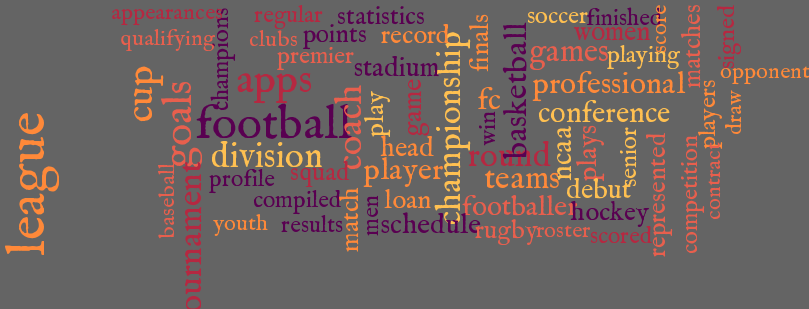

In [15]:
create_cloud('./{0}_toptopic.png'.format(name), wiki_words)
Image(filename='./{0}_toptopic.png'.format(name)) 

In [17]:
wikitopics = []
df_wikitopics = []
weights_list = weights.tolist()

for weight in weights_list:
    wikitopics.append([(w, f) for w, f in wiki_model.show_topic(weights_list.index(weight), 64)])
    df_wikitopics.append([[(w, f) for w, f in wiki_model.show_topic(weights_list.index(weight), 64)], weight])

In [18]:
# Slice of Wiki Topic Weights
df_wikitopics = pd.DataFrame(df_wikitopics, columns=('topics', 'weights'))
df_wikitopics = df_wikitopics.sort_values(by='weights', ascending=False)

In [19]:
fraction_mention = np.mean(wiki_topicx.topics[:,weights.argmax()] > 0)
print("The most mentioned topic is in {:.1%} of documents.".format(fraction_mention))
total_weight = np.mean(wiki_topicx.topics[:,weights.argmax()])
print("It represents {:.1%} of the total number of words.".format(total_weight))

The most mentioned topic is in 12.6% of documents.
It represents 5.7% of the total number of words.



**previous analysis ->**
This wordcloud is the culmination of our efforts. A word representation of the most heavily used topic on Wikipedia, with the top 64 words in the topic. Looking at this, we can most definitely see a theme arise. **This topic lands somewhere in the vein of 'Stories'**, be it written or on film. The two largest words within the topic are '```story```', and '```plot```', and the rest of the words that follow support that general theme, characters, places, writing, novel, episodes, reception, themes.

I would chance a guess that a good number of articles have a lot of crossover between writing and film, but it's not at all surprising to see this very identifiable topic float to the topic of the model. Conversely, lets take a look at whats on the bottom of our 100 topic model.

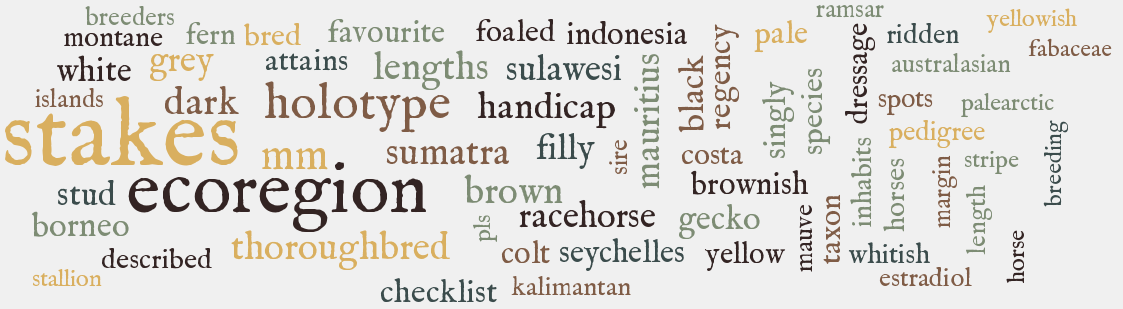

In [45]:
# topic 24
create_cloud('./{0}_top2topic.png'.format(name), df_wikitopics.loc[3, 'topics']
             , fontname='IM Fell DW Pica'
             , colors=COLOR_SCHEMES['oldschool']
             , background=(240, 240, 240, 255)
             , maxsize=90
             , minsize=10)
Image(filename='./{0}_top2topic.png'.format(name)) 

In [30]:
import pprint as pp
pp.pprint(df_wikitopics.loc[3, 'topics'])

[('stakes', 0.0271018),
 ('ecoregion', 0.01832645),
 ('holotype', 0.010251936),
 ('mm', 0.008584316),
 ('dark', 0.006982254),
 ('brown', 0.0068377154),
 ('sumatra', 0.0068256655),
 ('lengths', 0.0067776437),
 ('thoroughbred', 0.006584981),
 ('handicap', 0.0064227157),
 ('mauritius', 0.006042576),
 ('filly', 0.005923053),
 ('grey', 0.005829844),
 ('racehorse', 0.0057380786),
 ('sulawesi', 0.005728054),
 ('black', 0.0056892885),
 ('gecko', 0.0053620096),
 ('borneo', 0.005218394),
 ('white', 0.005163248),
 ('stud', 0.0051584183),
 ('checklist', 0.00503992),
 ('regency', 0.0050009643),
 ('indonesia', 0.0048633087),
 ('colt', 0.0048355116),
 ('pale', 0.004780036),
 ('singly', 0.0047443258),
 ('favourite', 0.0047157425),
 ('brownish', 0.004630443),
 ('seychelles', 0.004600497),
 ('taxon', 0.004562592),
 ('attains', 0.004517809),
 ('costa', 0.0044721416),
 ('foaled', 0.0044523887),
 ('bred', 0.0044299923),
 ('species', 0.0043581408),
 ('fern', 0.004239797),
 ('dressage', 0.0041537187),
 ('yel

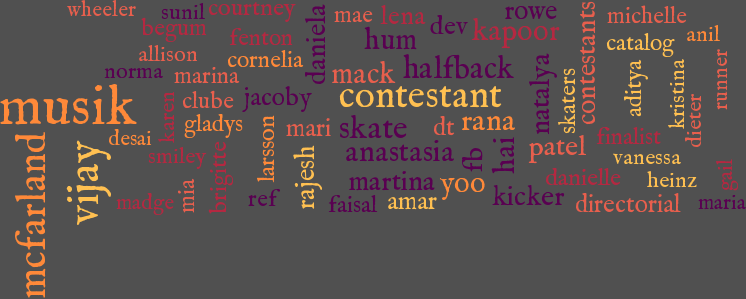

In [42]:
# topic 36
create_cloud('./{0}_top3topic.png'.format(name), df_wikitopics.loc[2, 'topics']
             , fontname='IM Fell DW Pica'
             , colors=COLOR_SCHEMES['audacity']
             , background=(80, 80, 80, 255)
             , maxsize=50
             , minsize=10)
Image(filename='./{0}_top3topic.png'.format(name)) 

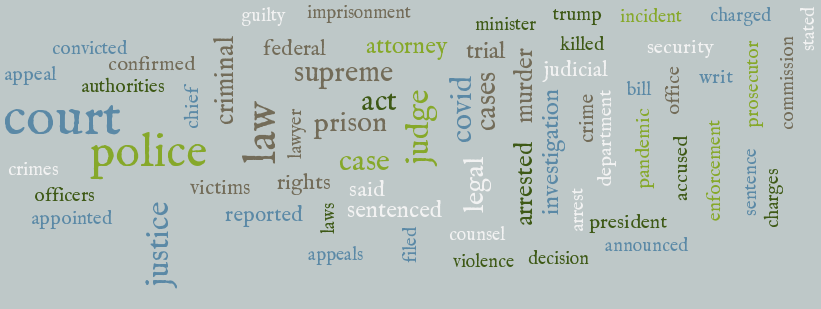

In [101]:
create_cloud('./{0}_wiki_crime.png'.format(name), df_wikitopics.loc[13, 'topics']
             , fontname='IM Fell DW Pica'
             , colors=COLOR_SCHEMES['scenic']
             , background=(190, 200, 200, 255)
             , maxsize=50
             , minsize=10)
Image(filename='./{0}_wiki_crime.png'.format(name)) 

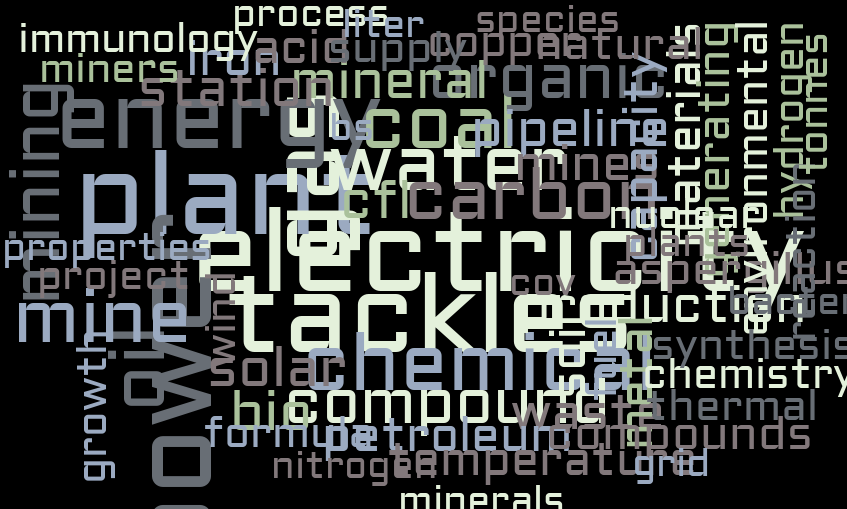

In [69]:
create_cloud('./{0}_wikienergytopic.png'.format(name), df_wikitopics.loc[84, 'topics']
             , fontname='Aldrich'
             , colors=COLOR_SCHEMES['lightly']
             , background=(0, 0, 0, 255)
             , maxsize=100
             , minsize=10
             , size=(1000, 500))
Image(filename='./{0}_wikienergytopic.png'.format(name)) 

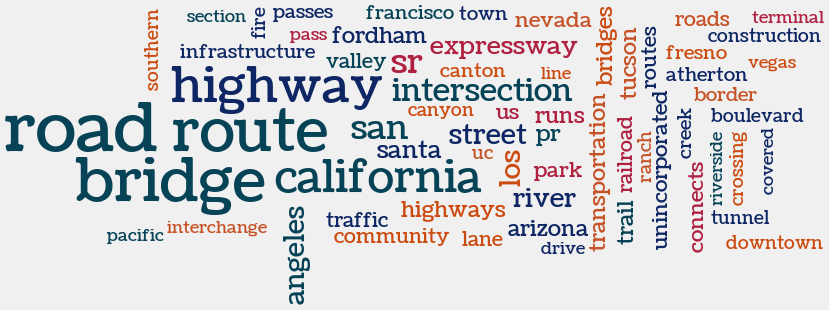

In [85]:
create_cloud('./{0}_california_transport.png'.format(name), df_wikitopics.loc[10, 'topics']
             , fontname='Coustard'
             , colors=COLOR_SCHEMES['sienna']
             , background=(240, 240, 240, 255)
             , maxsize=65
             , minsize=10)
Image(filename='./{0}_california_transport.png'.format(name)) 

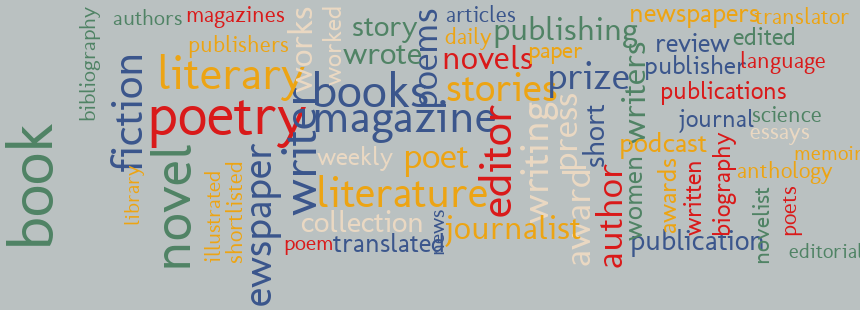

In [87]:
create_cloud('./{0}_literature.png'.format(name), df_wikitopics.loc[11, 'topics']
             , fontname='Molengo'
             , colors=COLOR_SCHEMES['stages']
             , background=(186, 193, 193, 255)
             , maxsize=60
             , minsize=11)
Image(filename='./{0}_literature.png'.format(name)) 

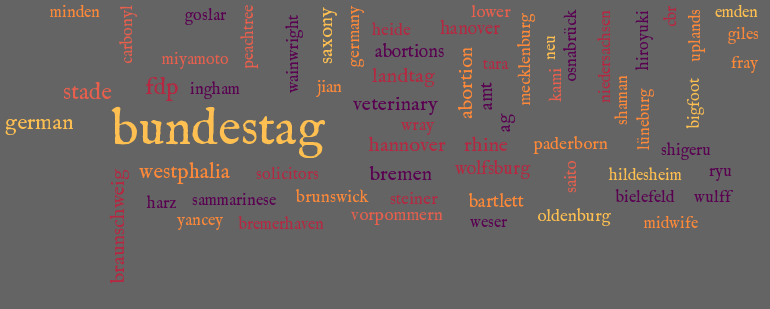

In [88]:
# Retrieve the most heavily used topic and plot it as a word cloud:
wiki_words = wiki_model.show_topic(weights.argmin(), 64)

create_cloud('./{0}_bottomtopic.png'.format(name), wiki_words)
Image(filename='./{0}_bottomtopic.png'.format(name)) 

In [97]:
fraction_mention = np.mean(wiki_topicx.topics[:,weights.argmin()] > 0)
print("The least mentioned topics is mentioned in {:.1%} of documents.".format(fraction_mention))
total_weight = np.mean(wiki_topicx.topics[:,weights.argmin()])
print("It represents {:.1%} of the total number of words.".format(total_weight))

The least mentioned topics is mentioned in 1.4% of documents.
It represents 0.1% of the total number of words.


This topic is definitely less clear, but when you start to think about these terms as a whole, and put them in context it becomes a little more clear. The countries are all in a specific part of West Africa, and according to Wikipedia, halopgroups are 'pertain to a single line of descent, usually dating back thousands of years'. Aside from that, there are some other interesting trends that got lumped in with this topic, many medical and research based terms. It's hard to say exactly what is going on here without further investigation, but it's certainly interesting.

- When it comes to picking the **number of topics** with LDA you want in your model it really is up to the task at hand, and what you as the engineer or research scientist feel is appropriate. 
- The same can be said for the **alpha** value; while changing this latter value may change the output, the results should still be robust.

After this project, we truly have the best words.

### Hierachical Dirichlet Process

This an an alternative process to LDA which will do a few things differently, such as choose the number of topics for you automatically. In general, instead of having a fixed number of topics, the topics are generated one at a time, just like the documents. So, the more documents in the dataset, the more topics you will end up with.

To test this model out, it's a call in gensim very similar to what we used for LDA, and it takes even longer to build - so remain patient. This model can be used in pretty much the exact same way as the LDA model, except the main difference is the model infered the number of topics automatically.

In [7]:
# Create Model - WARNING CALLING THIS TAKES SEVERAL HOURS
#hdp_wiki_model = models.hdpmodel.HdpModel(
#        corpus=wiki_corpus,
#        id2word=wiki_vocab,
#        chunksize=10000gamma)

#hdp_wiki_model.save('{0}_hdp.pkl'.format(name))

hdp_wiki_model = models.hdpmodel.HdpModel.load('{0}_hdp.pkl'.format(name))

2018-06-07 15:55:58,869 : INFO : loading HdpModel object from wiki_hdp.pkl
2018-06-07 15:55:59,054 : INFO : loading corpus recursively from wiki_hdp.pkl.corpus.* with mmap=None
2018-06-07 15:55:59,055 : INFO : loading id2word recursively from wiki_hdp.pkl.id2word.* with mmap=None
2018-06-07 15:55:59,057 : INFO : loading lda_beta from wiki_hdp.pkl.lda_beta.npy with mmap=None
2018-06-07 15:55:59,117 : INFO : loading m_lambda from wiki_hdp.pkl.m_lambda.npy with mmap=None
2018-06-07 15:55:59,174 : INFO : loading m_Elogbeta from wiki_hdp.pkl.m_Elogbeta.npy with mmap=None
2018-06-07 15:55:59,233 : INFO : loaded wiki_hdp.pkl


In [8]:
len(hdp_wiki_model.get_topics())

150

In [9]:
# Slightly different means of getting number of topics, so pulled this function out of the class

#wiki_hdptopicx = np.zeros((len(wiki_corpus)
#                         , len(hdp_wiki_model.get_topics())))
#for di, doc in enumerate(wiki_corpus):
#    for ti, v in hdp_wiki_model[doc]:
#        wiki_hdptopicx[di, ti] += v
                          
#with bz2.BZ2File('{0}_hdptopics.pkl.bz2'.format(name), 'wb') as f:
#    pkl.dump(wiki_topicx, f)

with bz2.open('{0}_hdptopics.pkl.bz2'.format(name), 'rb') as f:
        wiki_hdptopicx = pkl.load(f)

In [10]:
# Compute the number of topics mentioned in each article
lenshpd = (wiki_hdptopicx.topics > 0).sum(axis=1)

print('Mean number of topics mentioned: {0:.3}'.format(np.mean(lenshpd)))
print('Percentage of articles mentioning less than 10 topics: {0:.1%}'.format(np.mean(lenshpd <= 10)))

# Weights are total weight of words within each topic
weightshdp = wiki_hdptopicx.topics.sum(axis=0)

# Retrieve the most heavily used topic and plot it as a word cloud:
wiki_words = hdp_wiki_model.show_topic(weightshdp.argmax(), 64)


wikihdptopics = []
df_wikihdptopics = []
weights_hdplist = weightshdp.tolist()

for weight in weights_hdplist:
    wikihdptopics.append([(w, f) for w, f in hdp_wiki_model.show_topic(weights_hdplist.index(weight), 64)])
    df_wikihdptopics.append([[(w, f) for w, f in hdp_wiki_model.show_topic(weights_hdplist.index(weight), 64)], weight])
    
# Sclice of Wiki Topic Weights
df_wikihdptopics = pd.DataFrame(df_wikihdptopics, columns=('topics', 'weights'))
df_wikihdptopics = df_wikihdptopics.sort_values(by='weights', ascending=False)
df_wikihdptopics[:10] 

Mean number of topics mentioned: 6.25
Percentage of articles mentioning less than 10 topics: 94.8%


,topics,weights
27,"[(album, 0.000356434778502), (league, 0.000328...",263890.475760
24,"[(album, 0.000361463579064), (league, 0.000324...",208316.148287
36,"[(album, 0.000364006184843), (league, 0.000338...",181428.369071
61,"[(album, 0.000363271107298), (league, 0.000332...",171069.539215
44,"[(album, 0.000353961332019), (league, 0.000325...",166595.764108
95,"[(album, 0.00034053913863), (league, 0.0003164...",139287.724376
9,"[(album, 0.000364301531015), (league, 0.000334...",123099.277950
48,"[(album, 0.000349692604399), (league, 0.000324...",120332.157300
32,"[(album, 0.000344883068314), (league, 0.000331...",117032.923689
5,"[(album, 0.000365623698184), (league, 0.000329...",110064.393893


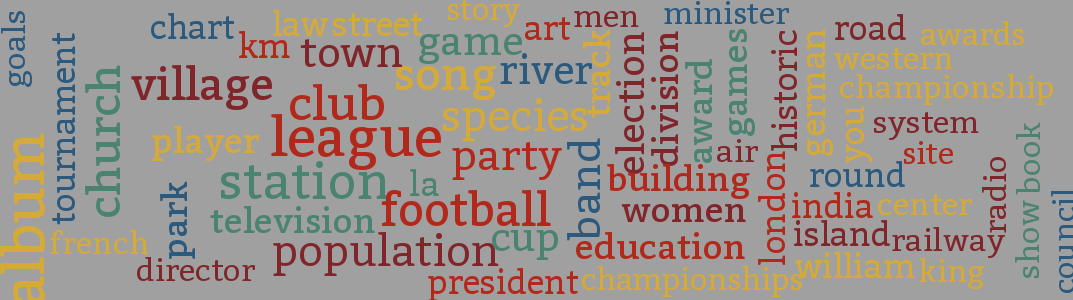

In [19]:
create_cloud('./{0}_hdptopic1.png'.format(name), df_wikihdptopics.loc[27, 'topics']
             , fontname='Bitter'
             , colors=COLOR_SCHEMES['highstakes']
             , background=(160, 160, 160, 255)
             , maxsize=40
             , minsize=5)
Image(filename='./{0}_hdptopic1.png'.format(name)) 

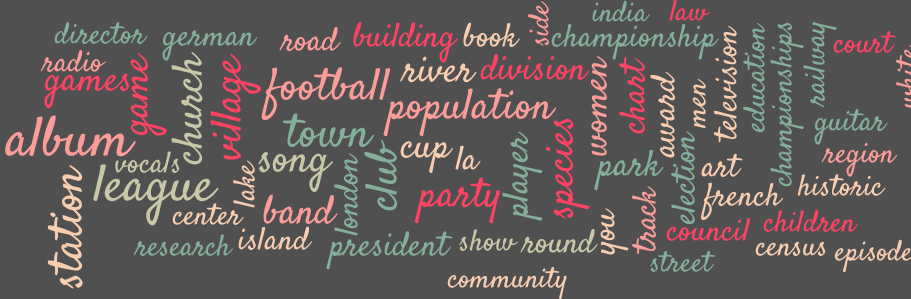

In [44]:
create_cloud('./{0}_hdptopic2.png'.format(name), df_wikihdptopics.loc[24, 'topics']
             , fontname='Satisfy'
             , colors=COLOR_SCHEMES['sugar']
             , background=(80, 80, 80, 255)
             , maxsize=40
             , minsize=5)
Image(filename='./{0}_hdptopic2.png'.format(name)) 

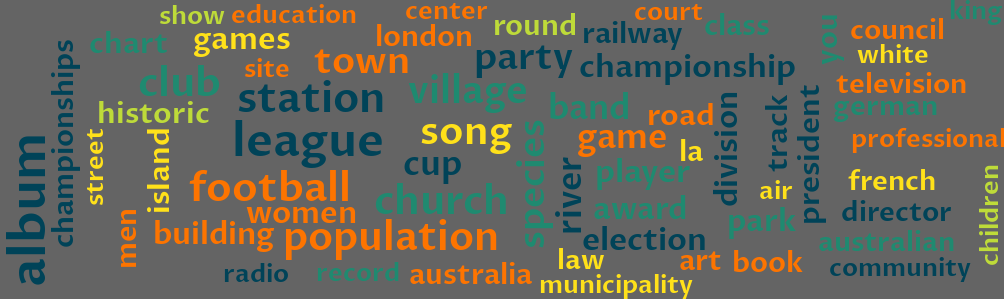

In [35]:
create_cloud('./{0}_hdptopic3.png'.format(name), df_wikihdptopics.loc[36, 'topics']
             , fontname='Proza Libre'
             , colors=COLOR_SCHEMES['vitamins']
             , background=(100, 100, 100, 255)
             , maxsize=35
             , minsize=5)
Image(filename='./{0}_hdptopic3.png'.format(name)) 

In [43]:
hdp_wiki_model.show_topics(num_topics=5, num_words=10)

[(0,
  '0.000*album + 0.000*league + 0.000*station + 0.000*village + 0.000*song + 0.000*club + 0.000*football + 0.000*population + 0.000*church + 0.000*game'),
 (1,
  '0.000*album + 0.000*league + 0.000*station + 0.000*club + 0.000*village + 0.000*football + 0.000*church + 0.000*town + 0.000*population + 0.000*song'),
 (2,
  '0.000*album + 0.000*league + 0.000*station + 0.000*football + 0.000*party + 0.000*village + 0.000*church + 0.000*club + 0.000*song + 0.000*species'),
 (3,
  '0.000*album + 0.000*league + 0.000*station + 0.000*club + 0.000*church + 0.000*football + 0.000*song + 0.000*village + 0.000*species + 0.000*population'),
 (4,
  '0.000*album + 0.000*league + 0.000*station + 0.000*football + 0.000*club + 0.000*song + 0.000*church + 0.000*village + 0.000*town + 0.000*species')]

We get a very different trend to the topics in the HDP model than we do in the LDA model. That is, the words in each topic seem to gradually morph into each new topic, with a lot of overlap between the topics as they go. This is not to be unexpected from the way the model learns builds the number of topics as it goes. In general, this type of model is more indicative of names of overall topic buckets than it is of subjects within each topic; for that kind of granularity, the LDA model delivers a more honed performance, and in general does a better job of delivering human comprehensible, and meaningful results.